In [1]:
import openpnm as op
import scipy as sp
% matplotlib inline
import matplotlib.pyplot as plt

In [2]:
pn = op.network.Cubic(shape=[200, 200])
geo = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)
air = op.phases.Air(network=pn)
water = op.phases.Water(network=pn)
phys = op.physics.Standard(network=pn, phase=air, geometry=geo)
phys2 = op.physics.Standard(network=pn, phase=water, geometry=geo)

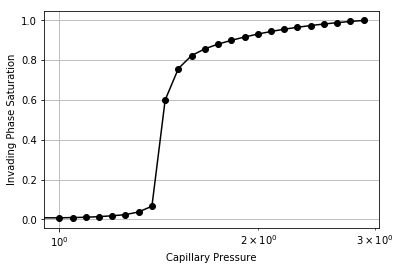

In [3]:
mip = op.algorithms.Porosimetry(network=pn)
mip.setup(phase=air)
mip.set_inlets(pores=pn.pores(['left', 'right']))
mip.run()
fig = mip.plot_intrusion_curve()

In [4]:
ip = op.algorithms.InvasionPercolation(network=pn)
ip.setup(phase=air)
ip.set_inlets(pores=pn.pores(['left']))
ip.run()

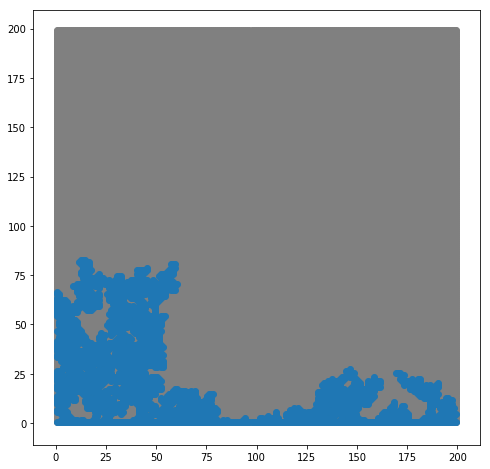

In [5]:
air.update(ip.results(Snwp=0.1))
fig = plt.figure(figsize=(8, 8))
fig = op.topotools.plot_coordinates(network=pn, color='grey', fig=fig)
fig = op.topotools.plot_coordinates(network=pn, fig=fig, pores=air['pore.occupancy'])

In [11]:
st = op.algorithms.StokesFlow(network=pn)
st.setup(phase=water)
st.set_value_BC(pores=pn.pores('front'), values=1)
st.set_value_BC(pores=pn.pores('back'), values=0)
air.update(ip.results(Snwp=0.1))
phys2['throat.hydraulic_conductance'][air['throat.occupancy']] = val
st.run()
water.update(st.results())

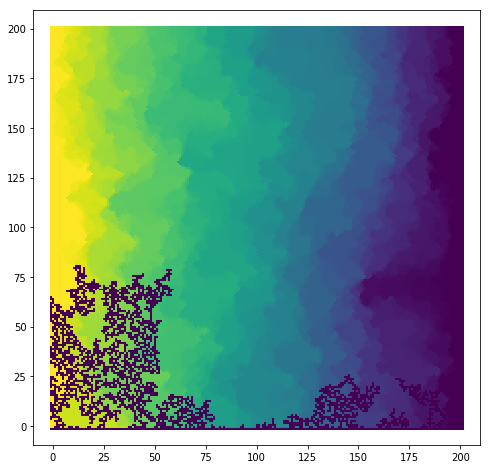

In [12]:
fig = plt.figure(figsize=(8, 8))
fig = op.topotools.plot_coordinates(network=pn, c=water['pore.pressure']*~air['pore.occupancy'], fig=fig,
                                    s=50, marker='s')

[[0.00000000e+00 5.04933699e-02]
 [1.00000000e-01 3.93234826e-02]
 [2.00000000e-01 2.62273506e-02]
 [3.00000000e-01 1.51502109e-02]
 [4.00000000e-01 1.11634994e-02]
 [5.00000000e-01 7.65283168e-03]
 [6.00000000e-01 4.48079511e-03]
 [7.00000000e-01 2.90343844e-03]
 [8.00000000e-01 1.08865762e-03]
 [9.00000000e-01 3.11593157e-05]]


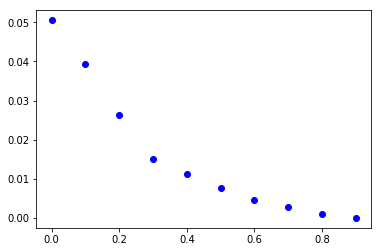

In [8]:
# This is where it gets a bit tricky becuase it must be done manually:
phys2.regenerate_models()
val = sp.amin(phys2['throat.hydraulic_conductance'])/1000
data = []
for s in sp.arange(0, 1, 0.1):
    air.update(ip.results(Snwp=s))
    water.update(st.results())
    phys2['throat.hydraulic_conductance'][air['throat.occupancy']] = val
    st.run()
    data.append([s, st.rate(pores=pn.pores('front'))[0]])
data = sp.vstack(data)
print(data)
plt.plot(*data.T, 'bo')
